In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def draw_pic(df, labels=None, filename='none'):
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df.values)
    if labels is None:
        plt.scatter(df_pca[:, 0], df_pca[:, 1], s=1)
    else:
        plt.scatter(df_pca[:, 0], df_pca[:, 1], s=1, c=1.0*labels)
    plt.savefig('./images/' + filename + '.png')

In [2]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

# Pre-processing

In [31]:
import os
import tarfile
from six.moves import urllib
import pandas as pd

student_raw = pd.read_csv('./data/page_count.csv')
student_raw = student_raw.set_index('id_student')
student_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 6516 to 2698588
Data columns (total 20 columns):
dataplus          26074 non-null int64
dualpane          26074 non-null int64
externalquiz      26074 non-null int64
folder            26074 non-null int64
forumng           26074 non-null int64
glossary          26074 non-null int64
homepage          26074 non-null int64
htmlactivity      26074 non-null int64
oucollaborate     26074 non-null int64
oucontent         26074 non-null int64
ouelluminate      26074 non-null int64
ouwiki            26074 non-null int64
page              26074 non-null int64
questionnaire     26074 non-null int64
quiz              26074 non-null int64
repeatactivity    26074 non-null int64
resource          26074 non-null int64
sharedsubpage     26074 non-null int64
subpage           26074 non-null int64
url               26074 non-null int64
dtypes: int64(20)
memory usage: 4.2 MB


In [4]:
student_raw.std().sort_values(ascending=False)

forumng           109.487846
subpage            70.108614
oucontent          68.911875
homepage           42.856821
quiz               41.180881
resource           28.940868
url                16.788280
ouwiki              9.503941
externalquiz        4.019454
oucollaborate       3.949132
ouelluminate        3.232823
questionnaire       3.195797
page                3.145411
glossary            2.415000
htmlactivity        1.030364
dualpane            0.920835
dataplus            0.656384
folder              0.152993
sharedsubpage       0.079879
repeatactivity      0.023171
dtype: float64

student_raw.std().sort_values(ascending=False)

0.966258385936


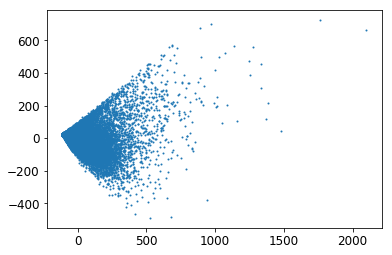

In [5]:
print(hopkins(student_raw))
draw_pic(student_raw)

## From activity type to Learning style

In [33]:
df = student_raw
student_8f = pd.DataFrame(index = df.index)
student_8f['motivational']=df['homepage']+df['quiz']
student_8f['communicational']=df['forumng']
student_8f['visual']=df['url']
student_8f['verbal']=df['resource']
student_8f['sensing']=df['dualpane']
student_8f['intuitive']=df['ouwiki']
student_8f['sequential']=df['subpage']
student_8f['global']=df['oucontent']
student_8f.describe()

,motivational,communicational,visual,verbal,sensing,intuitive,sequential,global
count,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000,26074.000000
mean,69.790519,68.990412,12.014957,23.393457,0.271765,4.342410,55.020288,53.188387
std,74.501734,109.487846,16.788280,28.940868,0.920835,9.503941,70.108614,68.911875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,6.000000,1.000000,6.000000,0.000000,0.000000,9.000000,4.000000
50%,50.000000,30.000000,6.000000,15.000000,0.000000,0.000000,25.000000,26.000000
75%,93.000000,87.000000,17.000000,30.000000,0.000000,5.000000,79.000000,75.000000
max,1266.000000,2044.000000,267.000000,422.000000,13.000000,131.000000,923.000000,633.000000


### Remove outliers and scaling

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

def array2df(array, df):
    df_copy = pd.DataFrame(data=array,
                         index = df.index,
                         columns = df.columns)
    return df_copy

df = student_8f
detecter = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
#outliers = detecter.fit_predict(df)
#draw_pic(df, outliers)
df['lof'] = detecter.fit_predict(df)
student_scaled = df[df['lof']>0]
print(len(student_scaled))
student_scaled = student_scaled.drop(columns=['lof'])
#student_scaled = student_8f

#scaler = MinMaxScaler()
#scaler.fit(student_scaled)
#student_scaled = array2df(scaler.transform(student_scaled), student_scaled)

student_scaled = array2df(normalize(student_scaled, norm='max'), student_scaled)

25813


0.860408645808


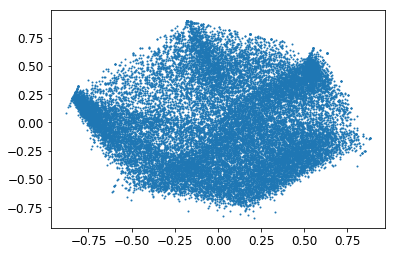

In [35]:
print(hopkins(student_scaled))
draw_pic(student_scaled)

Saving figure studentDataPre1


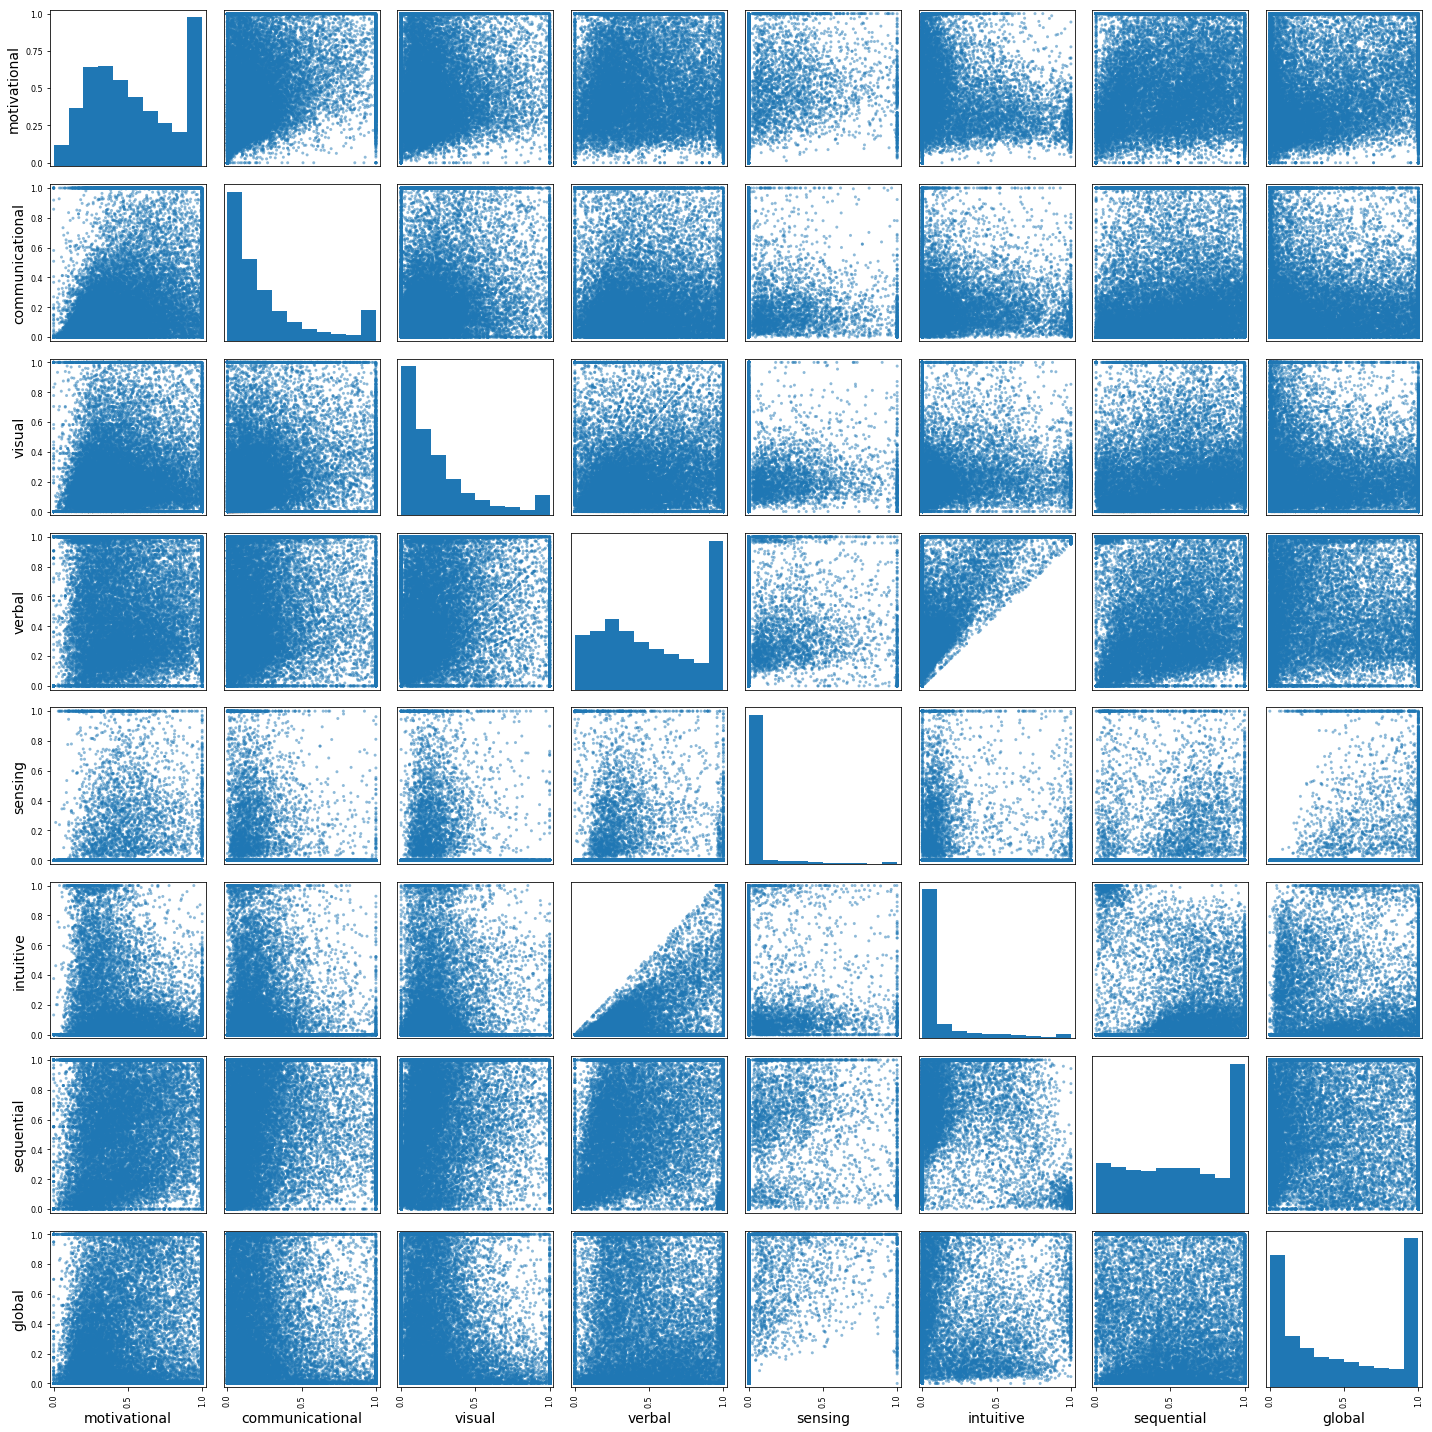

In [9]:
from pandas.plotting import scatter_matrix
student_8f = student_scaled
scatter_matrix(student_8f, figsize=(20, 20))
save_fig("studentDataPre1")

### K-means

In [36]:
from sklearn.cluster import KMeans

def clustering_kmeans(df, k=5):
    cluster_algo = KMeans(n_clusters=k, init='k-means++')
    cluster_algo.fit(df)
    return cluster_algo.labels_

In [37]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

def drawEvaluationGraph(params, sc_scores, ch_scores, paramname):
    fig = plt.figure(figsize=(8,6))
    ax_sc = fig.add_subplot(111)
    ax_sc.plot(params, sc_scores, 'r', label="Silhouette Coefficient")
    ax_sc.legend(loc=1)
    ax_sc.set_ylabel('SC Scores')
    ax_ch = ax_sc.twinx()
    ax_ch.plot(params, ch_scores, 'g', label="Calinski-Harabaz Index")
    ax_ch.legend(loc=2)
    ax_ch.set_ylabel('CH Scores')
    ax_ch.set_xlabel(paramname);
    plt.title('SC & CH scores')
    plt.grid(params)
    plt.show()
    print('Max SC:', max(sc_scores), ', K =',sc_scores.index(max(sc_scores)))
    print('Max CH:', max(ch_scores), ', K =',ch_scores.index(max(ch_scores)))
    plt.savefig('./images/' + paramname + '.png')

Clustering... 3
Clustering... 4
Clustering... 5
Clustering... 6
Clustering... 7
Clustering... 8
Clustering... 9
Clustering... 10


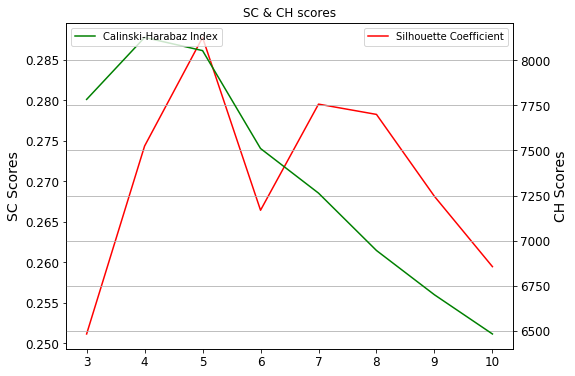

Max SC: 0.287742880101 , K = 2
Max CH: 8127.54254181 , K = 1


In [38]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

student_8f = student_scaled
labels_list = []
sc_score_list = []
ch_score_list = []
param_list = range(3, 11, 1)
for i in param_list:
    print('Clustering...', i)
    labels = clustering_kmeans(student_8f, i)
    labels_list.append(labels)
    sc_score_list.append(silhouette_score(student_8f, labels, metric='euclidean'))
    #sc_score_list.append(0)
    ch_score_list.append(calinski_harabaz_score(student_8f, labels))
drawEvaluationGraph(param_list, sc_score_list, ch_score_list, 'n_cluster')

In [27]:
print(sc_score_list)
print(ch_score_list)

[0.18423608539010791, 0.19046978078763638, 0.19959208143656951, 0.21103119839306239, 0.21870291856886848, 0.22716256465765403, 0.23233442900330697, 0.2288665304938983]
[5480.478300654273, 5170.3242431102599, 4924.0087753033886, 4798.8954523757784, 4717.6562565756758, 4675.143745358564, 4536.2158522467134, 4468.3490659095396]


### Cross validation

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import euclidean_distances
import math

np.random.seed(42)
def crossval(df, k=5, n=10):
    distances = []
    kfold = KFold(n_splits=n)
    for train_indices, test_indices in kfold.split(df): #注意index是否一致
        train_set = df.iloc[train_indices]
        test_set = df.iloc[test_indices]
        sum_dist = 0.0
        cluster_algo = KMeans(n_clusters=k, init='k-means++')
        cluster_algo.fit(train_set)
        distance_matrix = euclidean_distances(test_set, cluster_algo.cluster_centers_)
        for i in range(len(test_set)):
            sum_dist += math.sqrt(min(distance_matrix[i]))
        distances.append(sum_dist)
    return np.mean(distances), np.std(distances)

Clustering... 3
Clustering... 4
Clustering... 5
Clustering... 6


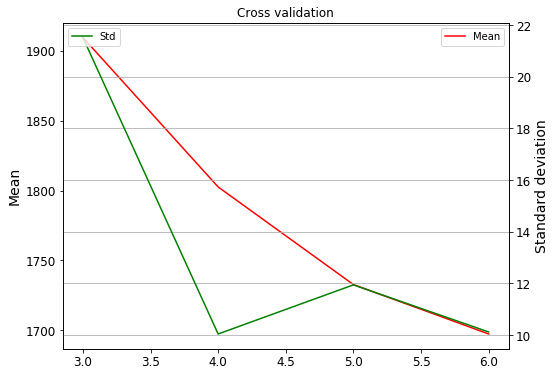

Min Mean: 1697.36686342 , K = 3
Min Std: 10.0394765749 , K = 1


In [11]:
def drawEvaluationGraph(params, sc_scores, ch_scores, paramname):
    fig = plt.figure(figsize=(8,6))
    ax_sc = fig.add_subplot(111)
    ax_sc.plot(params, sc_scores, 'r', label="Mean")
    ax_sc.legend(loc=1)
    ax_sc.set_ylabel('Mean')
    ax_ch = ax_sc.twinx()
    ax_ch.plot(params, ch_scores, 'g', label="Std")
    ax_ch.legend(loc=2)
    ax_ch.set_ylabel('Standard deviation')
    ax_ch.set_xlabel(paramname);
    plt.title('Cross validation')
    plt.grid(params)
    plt.show()
    print('Min Mean:', min(sc_scores), ', K =',sc_scores.index(min(sc_scores)))
    print('Min Std:', min(ch_scores), ', K =',ch_scores.index(min(ch_scores)))

student_8f = student_scaled
labels_list = []
sc_score_list = []
ch_score_list = []
param_list = range(3, 7, 1)
for i in param_list:
    print('Clustering...', i)
    mean, std = crossval(student_8f, k=i, n=10)
    sc_score_list.append(mean)
    ch_score_list.append(std)
drawEvaluationGraph(param_list, sc_score_list, ch_score_list, 'n_cluster')

### Stability

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import euclidean_distances
import math
from sklearn.cluster import KMeans

np.random.seed(42)
def stability(cluster_algo, df, k=5, n=10):
    results = pd.DataFrame(-1, index = df.index, columns=list(map(lambda i: 'col'+str(i), range(1,n+1))))
    kfold = KFold(n_splits=n)
    i=1
    for train_indices, test_indices in kfold.split(df): #注意index是否一致
        train_set = df.iloc[train_indices]
        results.loc[train_set.index,'col'+str(i)] = cluster_algo.fit_predict(train_set)
        i+=1
    #计算
    indexs_I = []
    indexs_J = []
    overlap_score = []
    for i in range(1,n+1):
        for j in range(i+1,n+1):
            indexs_I.clear()
            indexs_J.clear()
            overlap = 0.0
            for cluster in range(0,k):
                indexs_I.append(set(results.loc[results['col'+str(i)]==cluster].index))
                indexs_J.append(set(results.loc[results['col'+str(j)]==cluster].index))
            for index_set_I in indexs_I:
                max_overlap = 0.0
                for index_set_J in indexs_J:
                    overlap_per = float(len(index_set_I & index_set_J))/len(index_set_I | index_set_J)
                    if overlap_per > max_overlap: max_overlap = overlap_per
                overlap += max_overlap
            overlap_score.append(overlap/k)
    return np.mean(overlap_score), np.std(overlap_score)

def parameter_tunning_stability(df,branch_list,threshold_list,n_clusters_list):
    results = pd.DataFrame(columns=['branching_factor','threshold','n_clusters','stability_mean','stability_std'])
    record = pd.DataFrame(columns=['branching_factor','threshold','n_clusters','stability_mean','stability_std'], index=range(0,1))
    for factor in branch_list:
        record.iloc[0]['branching_factor'] = factor
        for x in threshold_list:
            record.iloc[0]['threshold'] = float(x)/10
            for k in n_clusters_list:
                record.iloc[0]['n_clusters'] = k
                brc = Birch(branching_factor=factor, n_clusters=k, threshold=float(x)/10, compute_labels=True)
                record.iloc[0]['stability_mean'], record.iloc[0]['stability_std'] = stability(brc, df, k, n=10)
                results = results.append(record, ignore_index=True)
    return results

Clustering... 3
Clustering... 4
Clustering... 5
Clustering... 6
Clustering... 7
Clustering... 8
Clustering... 9
Clustering... 10


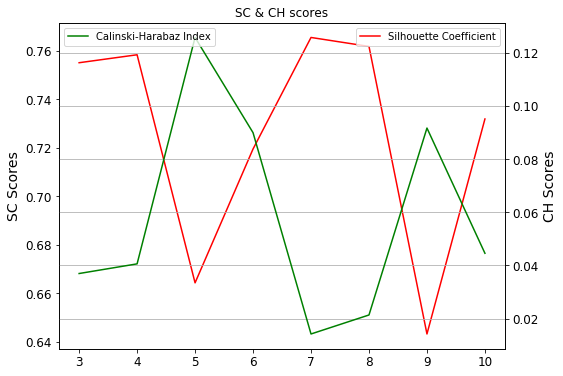

Max SC: 0.765401455702 , K = 4
Max CH: 0.125696082375 , K = 2


In [29]:
student_8f = student_scaled
labels_list = []
sc_score_list = []
ch_score_list = []
param_list = range(3, 11, 1)
for i in param_list:
    print('Clustering...', i)
    kmeans = KMeans(n_clusters=i, init='k-means++')
    mean, std = stability(kmeans, student_8f, k=i, n=10)
    sc_score_list.append(mean)
    ch_score_list.append(std)
drawEvaluationGraph(param_list, sc_score_list, ch_score_list, 'n_cluster')

In [30]:
print(sc_score_list)
print(ch_score_list)

[0.75498615224956733, 0.75826690759493132, 0.66422087500989069, 0.71941331965405375, 0.76540145570243145, 0.76170687947562132, 0.64313554863283839, 0.73179253523063437]
[0.036984802168090546, 0.040614107336156217, 0.12569608237530058, 0.089914815316022315, 0.014265814709370413, 0.021404778461568793, 0.091650556973608063, 0.044590197756153797]


5


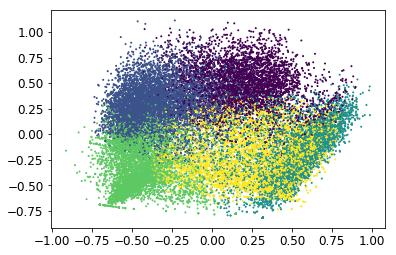

In [22]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

student_8f = student_scaled
student_labels = clustering_kmeans(student_8f, 5)
#print('SC:', silhouette_score(student_8f, student_labels, metric='euclidean'))
#print('CH:', calinski_harabaz_score(student_8f, student_labels))
print(max(student_labels)+1)
draw_pic(student_8f, student_labels, 'Kmeans5_validate')

In [20]:
student_8f.head()

,motivational,communicational,visual,verbal,sensing,intuitive,sequential,global
id_student,,,,,,,,
6516,0.654311,0.576674,0.800117,0.178896,0.0,0.000000,0.360517,1.000000
8462,0.313103,0.118573,0.569137,0.679084,0.0,0.294454,1.000000,0.278800
11391,0.514724,0.472552,0.113410,0.288680,0.0,0.000000,0.148291,1.000000
23629,1.000000,0.605925,0.000000,0.231348,0.0,0.000000,0.118841,0.000000
23698,1.000000,0.193193,0.158064,0.382227,0.0,0.000000,0.444360,0.037166


In [13]:
student_8f.to_csv('./data/student_cluster.csv')

In [14]:
student_kmeans = student_8f
student_kmeans['cluster'] = student_labels
student_kmeans.head()

,motivational,communicational,visual,verbal,sensing,intuitive,sequential,global,cluster
id_student,,,,,,,,,
6516,0.763889,1.000000,0.256944,0.090278,0.0,0.00000,0.354167,0.819444,1
8462,0.372093,0.209302,0.186047,0.348837,0.0,0.05814,1.000000,0.232558,4
11391,0.733333,1.000000,0.044444,0.177778,0.0,0.00000,0.177778,1.000000,3
23629,1.000000,0.900000,0.000000,0.100000,0.0,0.00000,0.100000,0.000000,0
23698,1.000000,0.286957,0.043478,0.165217,0.0,0.00000,0.373913,0.026087,2


In [15]:
student_kmeans.to_csv('./data/student_kmeans_validate.csv')